# Optimizing Hospital Readmission Reduction Using Patient Clustering

**Author:** Deep Manish Mehta  
**Date:** April 29, 2025  
**Course:** Practical Data Science – MS in Data Science, Pace University

---

## Project Overview

Hospital readmissions pose significant challenges by driving up healthcare costs and reducing patient satisfaction. Traditional predictive models often lack explainability regarding the underlying causes of readmissions. This project introduces an innovative unsupervised learning framework that not only identifies hidden, high-risk patient subgroups but also explains the key factors driving these outcomes. The ultimate goal is to inform targeted interventions that can reduce readmission rates.

---

## Project Goal

- **Develop an unsupervised learning framework** to cluster patients based on healthcare utilization and clinical severity.
- **Transform clustering results** into actionable insights using explainable AI techniques.
- **Support strategic decision-making** for reducing hospital readmissions through targeted interventions.

---

## Methodology

1. **Data Cleaning & Preprocessing**
   - Replace missing values and remove duplicates.
   - Drop irrelevant or redundant columns.
   - Encode categorical variables and engineer additional features such as total visits, outpatient ratio, and severity score.

2. **Exploratory Data Analysis (EDA)**
   - Visualize data distributions and relationships (e.g., readmission status, age groups, race, gender).
   - Create correlation matrices to understand feature interactions.

3. **Clustering with HDBSCAN**
   - Scale features and perform PCA for dimensionality reduction.
   - Apply HDBSCAN to identify patient subgroups, handling noise points appropriately.

4. **Interpretation with SHAP**
   - Convert unsupervised clusters into binary targets.
   - Train Random Forest classifiers in a one-vs-rest framework.
   - Use SHAP analysis to determine key features driving each patient subgroup.

5. **Model Evaluation**
   - Validate clusters with cross-validation scores, train/test accuracies, and silhouette scores.
   - Generate detailed profiles for each cluster (Low Engagement, Moderate Utilization, High Risk).

---

## Quick Start

To begin, ensure all required libraries are installed:

```python
!pip install pandas numpy matplotlib seaborn scikit-learn hdbscan shap
```

Then, load and preprocess the data as described. For full details, refer to the subsequent cells in this notebook.

---


In [153]:
#!pip install pandas numpy matplotlib seaborn scikit-learn hdbscan shap

In [154]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Exploration


In [155]:
# Load and Inspect the Dataset
df = pd.read_csv('diabetic_data.csv')
print("Data shape:", df.shape)
print("First few rows of the dataset:")
df.head()

Data shape: (101766, 50)
First few rows of the dataset:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [156]:
# Getting information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Data Cleaning

In [157]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [158]:
# Replace missing value indicators ('?') with NaN
df.replace('?', np.nan, inplace=True)

In [159]:
# Check missing values
print("\nMissing values after replacing '?':")
print(df.isna().sum())


Missing values after replacing '?':
encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride

In [160]:
# Drop columns that are not useful or have too many missing values.
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
for col in cols_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [161]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nData shape after dropping missing values:", df.shape)


Data shape after dropping missing values: (289, 45)


In [162]:
print("\nCleaned data preview:")
df.head()


Cleaned data preview:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
162,Caucasian,Male,[80-90),6,3,7,5,47,1,6,...,No,No,No,No,No,No,No,No,No,<30
460,AfricanAmerican,Female,[70-80),6,1,7,10,72,1,19,...,No,Up,No,No,No,No,No,Ch,Yes,>30
593,Caucasian,Female,[50-60),6,1,7,2,61,0,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
696,Other,Male,[70-80),6,6,7,11,71,1,20,...,No,No,No,No,No,No,No,No,Yes,NO
771,Caucasian,Female,[30-40),6,1,2,14,43,0,11,...,No,No,No,No,No,No,No,No,No,>30


## Exploratory Data Analysis (EDA)

- Exploratory Data Analysis (EDA) is an approach to analyzing datasets to summarize their main characteristics, often with visual methods.
- It involves looking at data patterns, identifying potential relationships between variables, detecting outliers, and testing underlying assumptions.

In [163]:
# Mapping for the "readmitted" column.
# Typical values: "<30", ">30", "NO"
readmit_labels = {
    "<30": "Readmitted <30 Days",
    ">30": "Readmitted >30 Days",
    "NO": "No Readmission"
}

In [164]:
# Mapping for "age" if it's given as ranges in string format.
# Typical values: "[0-10)", "[10-20)", "[20-30)", "[30-40)", "[40-50)",
# "[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-100)"
age_map = {
    "[0-10)": "0-10",
    "[10-20)": "10-20",
    "[20-30)": "20-30",
    "[30-40)": "30-40",
    "[40-50)": "40-50",
    "[50-60)": "50-60",
    "[60-70)": "60-70",
    "[70-80)": "70-80",
    "[80-90)": "80-90",
    "[90-100)": "90-100"
}

In [165]:
# Mapping for "race" if the column contains string values.
# Typical values: "Caucasian", "AfricanAmerican", "Asian", "Hispanic", "Other"
race_map = {
    "Caucasian": "Caucasian",
    "AfricanAmerican": "African American",
    "Asian": "Asian",
    "Hispanic": "Hispanic",
    "Other": "Other"
}

In [166]:
# Optionally, if you want to map gender (if your data uses codes or other variants)
gender_map = {
    "Female": "Female",
    "Male": "Male"
}

In [167]:
# Create a column with descriptive readmission labels.
# Only do this if the readmitted column is still in string format.
if 'readmitted' in df.columns:
    df['readmitted_label'] = df['readmitted'].map(readmit_labels)

# Create a column for age groups if age is categorical (e.g., "[0-10)").
if 'age' in df.columns:
    df['age_group'] = df['age'].map(age_map)

# Create a column for race labels if needed.
if 'race' in df.columns:
    df['race_label'] = df['race'].map(race_map)

# Create a column for gender labels if needed.
if 'gender' in df.columns:
    # Uncomment the next line if your gender column needs mapping.
    # df['gender_label'] = df['gender'].map(gender_map)
    # Otherwise, you can use the existing column.
    df['gender_label'] = df['gender']

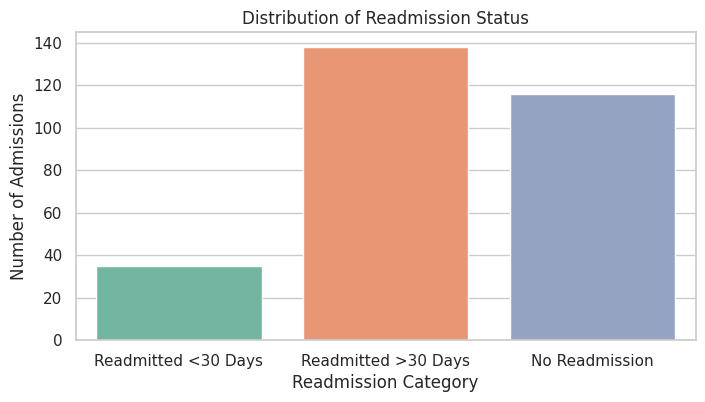

In [168]:
sns.set(style="whitegrid")
# ------------------------------
# Plot 1: Distribution of Readmission Status
# ------------------------------
plt.figure(figsize=(8, 4))
sns.countplot(x='readmitted_label', data=df, palette='Set2')
plt.title('Distribution of Readmission Status')
plt.xlabel('Readmission Category')
plt.ylabel('Number of Admissions')
plt.show()

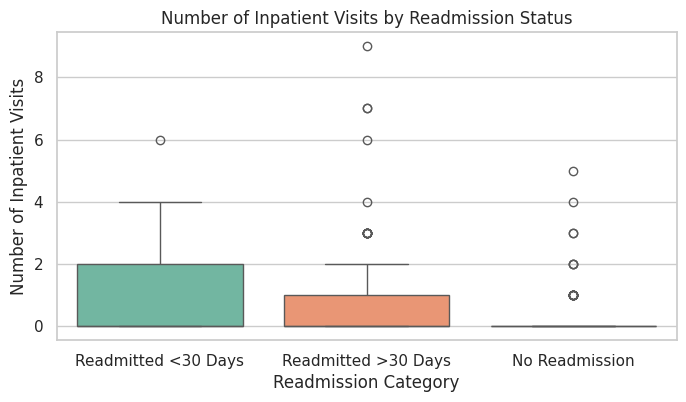

In [169]:
# ------------------------------
# Plot 2: Boxplot - Number of Inpatient Visits by Readmission
# ------------------------------
# This plot uses the raw "readmitted" for grouping; if you want labels, use "readmitted_label"
if 'number_inpatient' in df.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='readmitted_label', y='number_inpatient', data=df, palette='Set2')
    plt.title('Number of Inpatient Visits by Readmission Status')
    plt.xlabel('Readmission Category')
    plt.ylabel('Number of Inpatient Visits')
    plt.show()

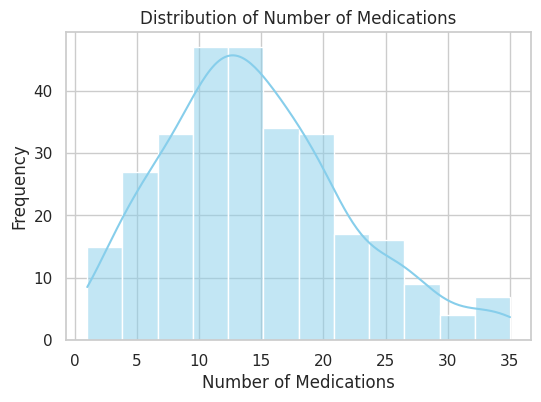

In [170]:
# ------------------------------
# Plot 3: Histogram - Number of Medications
# ------------------------------
if 'num_medications' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df['num_medications'].dropna(), kde=True, color='skyblue')
    plt.title('Distribution of Number of Medications')
    plt.xlabel('Number of Medications')
    plt.ylabel('Frequency')
    plt.show()

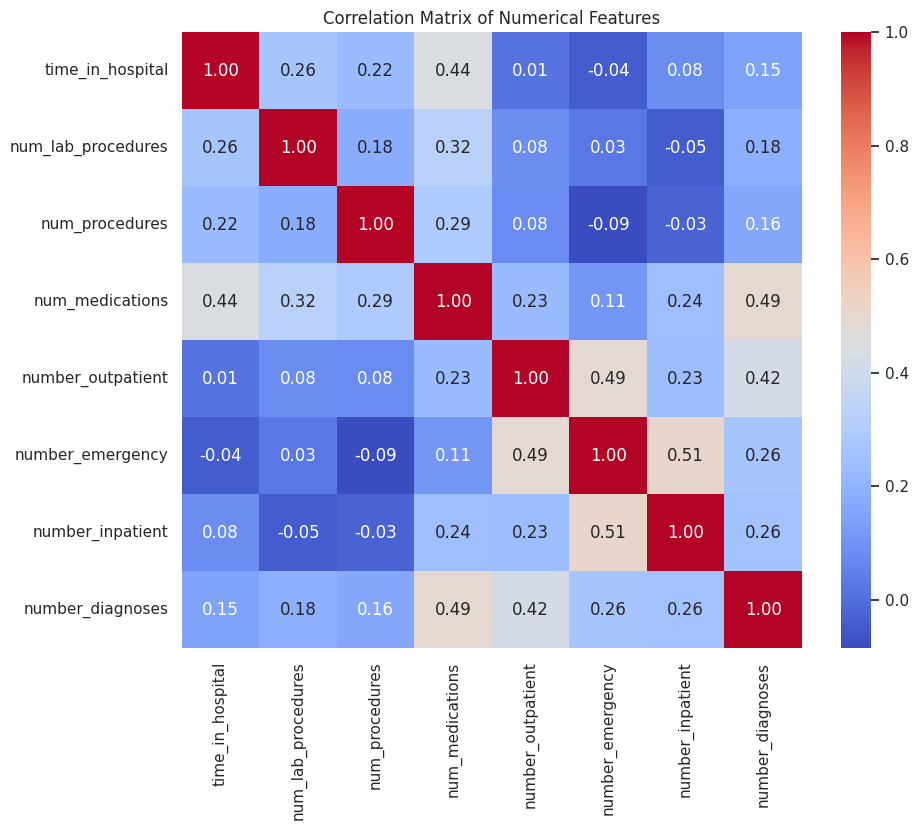

In [171]:
# ------------------------------
# Plot 4: Correlation Heatmap for Selected Numerical Features
# ------------------------------
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                      'num_medications', 'number_outpatient', 'number_emergency',
                      'number_inpatient', 'number_diagnoses']
available_numerical = [feat for feat in numerical_features if feat in df.columns]
if available_numerical:
    plt.figure(figsize=(10, 8))
    corr_matrix = df[available_numerical].astype(float).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

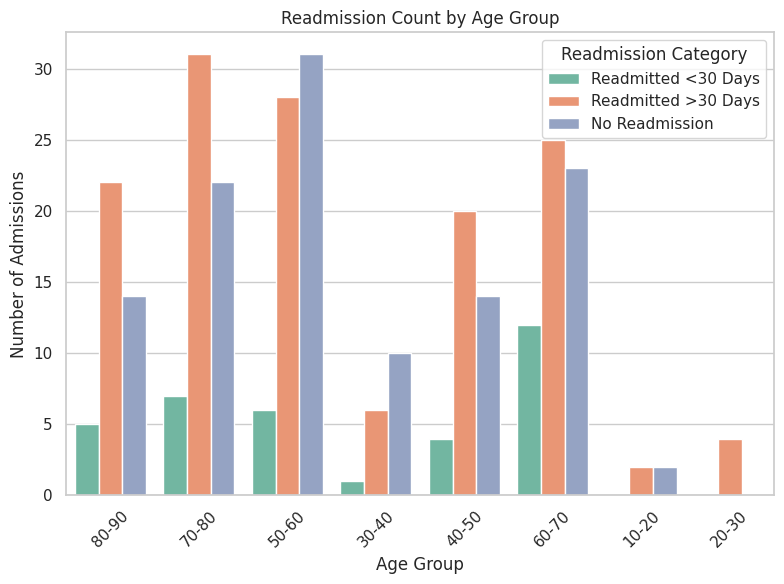

In [172]:
# ------------------------------
# Plot 5: Age vs Readmission (using mapped age groups)
# ------------------------------
if 'age_group' in df.columns and 'readmitted_label' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x='age_group', hue='readmitted_label', data=df, palette='Set2')
    plt.title('Readmission Count by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Number of Admissions')
    plt.legend(title='Readmission Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


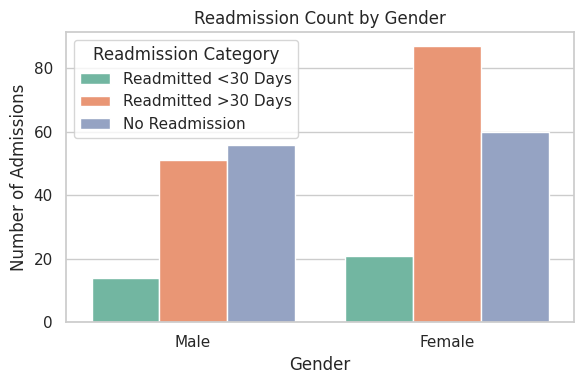

In [173]:
# ------------------------------
# Plot 6: Gender vs Readmission
# ------------------------------
if 'gender_label' in df.columns and 'readmitted_label' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='gender_label', hue='readmitted_label', data=df, palette='Set2')
    plt.title('Readmission Count by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Number of Admissions')
    plt.legend(title='Readmission Category')
    plt.tight_layout()
    plt.show()

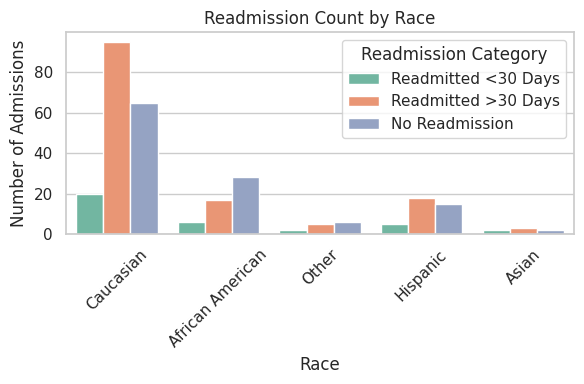

In [174]:
# ------------------------------
# Plot 7: Race vs Readmission
# ------------------------------
if 'race_label' in df.columns and 'readmitted_label' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='race_label', hue='readmitted_label', data=df, palette='Set2')
    plt.title('Readmission Count by Race')
    plt.xlabel('Race')
    plt.ylabel('Number of Admissions')
    plt.legend(title='Readmission Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Feature Engineering

In [175]:
# 5.1 Convert 'age' from range to numeric if needed
def age_to_numeric(age_str):
    if pd.isna(age_str):
        return np.nan
    age_str = age_str.strip('[]').replace(")", "")
    lower, upper = age_str.split('-')
    return (int(lower) + int(upper)) / 2

In [176]:
if df['age'].dtype == object:
    df['age'] = df['age'].apply(age_to_numeric)

In [177]:
# --- 5.2 Encode Medication Columns ---
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

In [178]:
def encode_medication(val):
    """
    Convert medication change strings ("Up", "Down", "Steady", "No") to numeric.
    """
    if val == 'No':
        return 0
    elif val == 'Down':
        return -1
    elif val == 'Up':
        return 1
    elif val == 'Steady':
        return 0
    else:
        return 0

for col in med_cols:
    if col in df.columns:
        df[col] = df[col].apply(encode_medication)

In [179]:
# 5.3 One-Hot Encode Selected Categorical Columns for modeling
categorical_cols = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
cols_to_encode = [col for col in categorical_cols if col in df.columns]
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

In [180]:
# 5.4 Create Additional Features
# total_visits: Sum of outpatient, emergency, and inpatient visits.
if all(col in df.columns for col in ['number_outpatient', 'number_emergency', 'number_inpatient']):
    df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [181]:
# follow_up_compliance: Flag if outpatient visits > 2 (adjust threshold as needed).
if 'number_outpatient' in df.columns:
    df['follow_up_compliance'] = df['number_outpatient'].apply(lambda x: 1 if x > 2 else 0)

In [182]:
# medication_count: Count of medication changes (using absolute values so both "Up" and "Down" count).
if all(col in df.columns for col in med_cols):
    df['medication_count'] = df[med_cols].abs().sum(axis=1)

In [183]:
# NEW FEATURE: outpatient_ratio - ratio of outpatient visits to total visits.
if all(col in df.columns for col in ['number_outpatient', 'total_visits']):
    df['outpatient_ratio'] = df['number_outpatient'] / df['total_visits']
    df['outpatient_ratio'].fillna(0, inplace=True)

In [184]:
# NEW FEATURE: severity_score - average of normalized counts for lab procedures, medications, and diagnoses.
if all(col in df.columns for col in ['num_lab_procedures', 'num_medications', 'number_diagnoses']):
    df['severity_score'] = (df['num_lab_procedures'] + df['num_medications'] + df['number_diagnoses']) / 3

In [185]:
# =========================================
# 1) Domain-Specific Feature: Comorbidity
# =========================================
if all(col in df.columns for col in ['diag_1','diag_2','diag_3']):
    def count_comorbidities(row):
        unique_diags = set([row['diag_1'], row['diag_2'], row['diag_3']])
        unique_diags.discard(np.nan)
        return len(unique_diags)
    df['comorbidity_count'] = df.apply(count_comorbidities, axis=1)

In [186]:
# =========================================
# 2) Ratios & Interaction
# =========================================
if all(col in df.columns for col in ['number_inpatient','total_visits']):
    df['inpatient_ratio'] = df['number_inpatient'] / df['total_visits']
    df['inpatient_ratio'] = df['inpatient_ratio'].fillna(0)

if all(col in df.columns for col in ['time_in_hospital','number_diagnoses']):
    df['hospital_days_per_dx'] = df['time_in_hospital'] / (df['number_diagnoses'] + 1)

In [187]:
# =========================================
# 3) Outlier Handling Example
# =========================================
upper_limit_days = 14
df['time_in_hospital_capped'] = np.where(
    df['time_in_hospital'] > upper_limit_days,
    upper_limit_days,
    df['time_in_hospital']
)

In [188]:
# If needed, log transform a column, e.g. 'num_medications'
df['num_medications_log'] = np.log1p(df['num_medications'])

In [189]:
print("\nColumns after feature engineering:")
print(df.columns)
for col in ['total_visits', 'follow_up_compliance', 'medication_count', 'outpatient_ratio', 'severity_score']:
    if col in df.columns:
        print(f"\n{col} stats:")
        print(df[col].describe())


Columns after feature engineering:
Index(['age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'readmitted', 'readmitted_label', 'age_group',
       'race_label', 'gender_label', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Male', 'max_glu_serum_>300',
       'max_glu_serum_Norm', 'A1Cresult_>8

In [190]:
df

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,total_visits,follow_up_compliance,medication_count,outpatient_ratio,severity_score,comorbidity_count,inpatient_ratio,hospital_days_per_dx,time_in_hospital_capped,num_medications_log
162,85.0,6,3,7,5,47,1,6,0,0,...,0,0,0,0.000000,19.333333,3,0.000000,0.833333,5,1.945910
460,75.0,6,1,7,10,72,1,19,0,0,...,0,0,2,0.000000,32.000000,3,0.000000,1.666667,10,2.995732
593,55.0,6,1,7,2,61,0,5,0,0,...,0,0,0,0.000000,23.666667,3,0.000000,0.333333,2,1.791759
696,75.0,6,6,7,11,71,1,20,0,0,...,0,0,0,0.000000,32.000000,3,0.000000,1.833333,11,3.044522
771,35.0,6,1,2,14,43,0,11,0,0,...,0,0,0,0.000000,19.000000,3,0.000000,3.500000,14,2.484907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100386,65.0,2,1,1,6,51,0,20,1,6,...,13,0,0,0.076923,26.666667,3,0.461538,0.600000,6,3.044522
100493,45.0,1,1,7,3,78,0,8,0,0,...,0,0,0,0.000000,31.666667,3,0.000000,0.300000,3,2.197225
100578,65.0,1,2,7,4,90,0,25,0,1,...,3,0,0,0.000000,41.333333,3,0.666667,0.400000,4,3.258097
101029,55.0,1,1,7,7,72,0,16,0,0,...,0,0,0,0.000000,32.333333,2,0.000000,0.700000,7,2.833213


##  Prepare Data for Clustering

In [191]:
# Remove columns that should not be used for clustering (e.g., readmission flag)
if 'readmitted_flag' in df.columns:
    X = df.drop(['readmitted_flag'], axis=1)
else:
    X = df.copy()

In [192]:
# Ensure all features are numeric.
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.Categorical(X[col]).codes

In [193]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

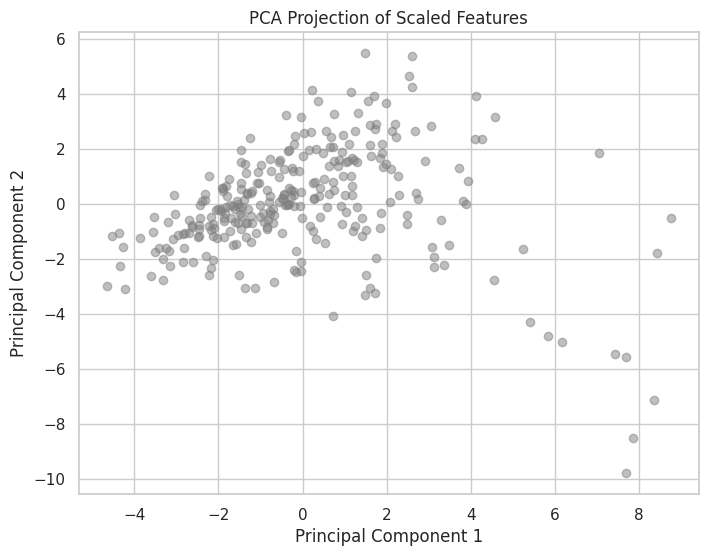

In [194]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='gray', alpha=0.5)
plt.title("PCA Projection of Scaled Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

##HDBSCAN Clustering

In [195]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
cluster_labels = clusterer.fit_predict(X_scaled)
print(f"HDBSCAN returned labels: {set(cluster_labels)}")
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters (excluding noise): {n_clusters}")

HDBSCAN returned labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(-1)}
Number of clusters (excluding noise): 3


In [196]:
# Add cluster labels to the dataframe
df['cluster_label'] = cluster_labels

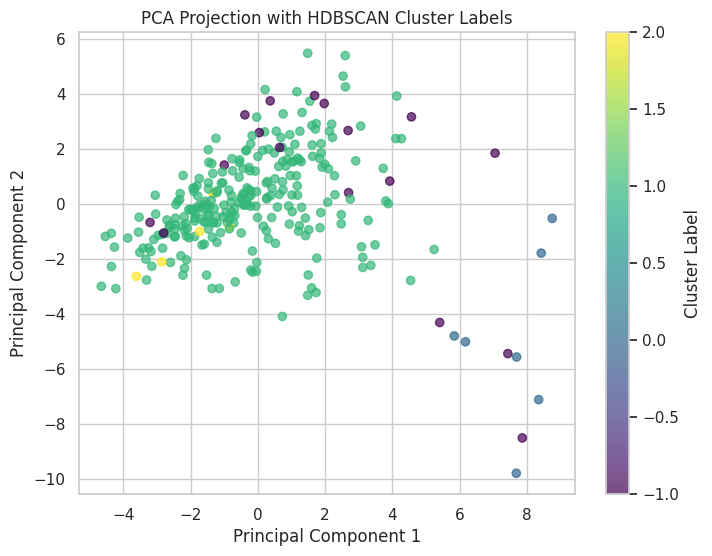

In [197]:
# Visualize clustering results with PCA projection
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.title("PCA Projection with HDBSCAN Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Cluster Evaluation

In [198]:
# Compute the silhouette score, excluding noise points (labeled as -1)
noise_mask = cluster_labels != -1
if noise_mask.sum() > 1:
    sil_score = silhouette_score(X_scaled[noise_mask], cluster_labels[noise_mask])
    print(f"Silhouette Score (excluding noise): {sil_score:.3f}")
else:
    print("Too few clustered points to compute silhouette score.")

Silhouette Score (excluding noise): 0.194


In [199]:
# Ensure that 'df' is the full dataset used for clustering (289 rows × 64 columns)
print("Data shape:", df.shape)  # Should print (289, 64)
print("Length of cluster_labels:", len(cluster_labels))  # Should print 289

# Assign cluster labels to the full DataFrame
if len(df) == len(cluster_labels):
    df['cluster_label'] = cluster_labels
else:
    raise ValueError("Mismatch in lengths. Check the DataFrame used for clustering.")

# Compute the mean values for key metrics by cluster
group_summary = df.groupby('cluster_label')[['total_visits', 'medication_count', 'severity_score']].mean()
print("Group Summary (Actual Numbers):")
print(group_summary)


Data shape: (289, 65)
Length of cluster_labels: 289
Group Summary (Actual Numbers):
               total_visits  medication_count  severity_score
cluster_label                                                
-1                 3.235294          1.117647       29.137255
 0                 8.000000          0.000000       35.904762
 1                 0.684615          0.138462       28.028205
 2                 0.000000          0.400000       25.066667


## Interpret Clusters with SHAP

In [200]:
cluster_names = {
    0: "High Risk",
    1: "Low Engagement",
    2: "Moderate Utilization"
}

# 2) Iterate over each cluster, build one-vs-rest model, and generate improved SHAP plots
unique_clusters = [c for c in df['cluster_label'].unique() if c != -1]


Cluster 1 vs. Rest: Low Engagement
5-fold CV scores: [0.89655172 0.89655172 0.94827586 0.9137931  0.96491228]
Mean CV Score: 0.9240169388989715
Train Accuracy: 0.987012987012987
Test Accuracy: 0.9137931034482759


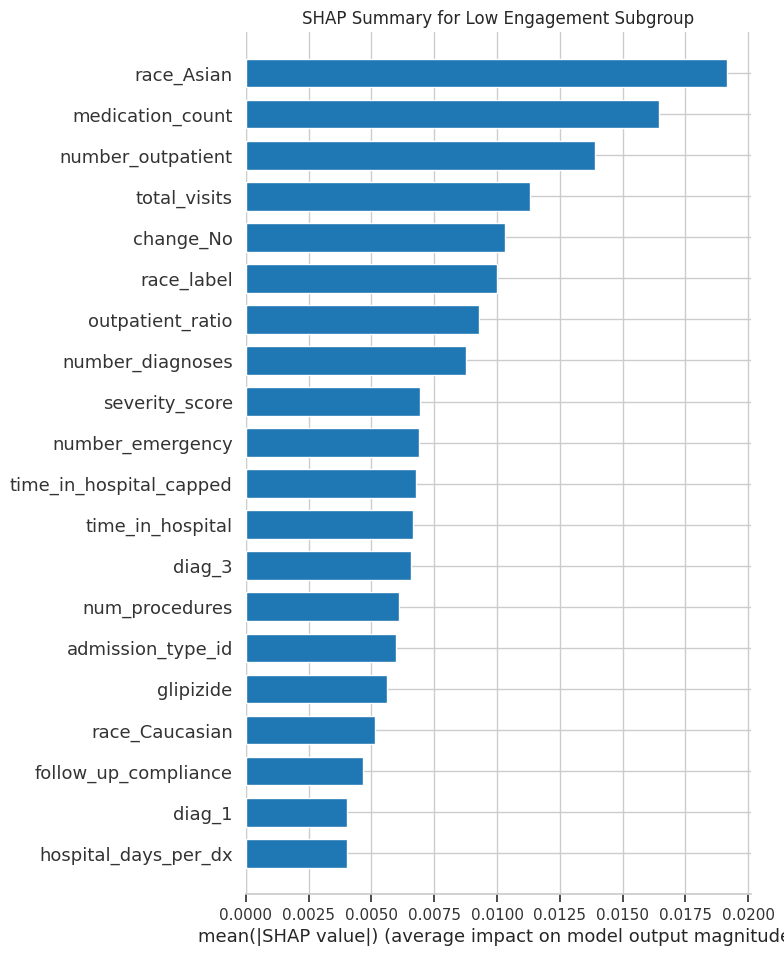

<Figure size 1200x800 with 0 Axes>


Top 5 features for Low Engagement: ['race_Asian', 'medication_count', 'number_outpatient', 'total_visits', 'change_No']
Low Engagement Profile:
                   count      mean       std  min  25%  50%  75%  max
medication_count   260.0  0.138462  0.346050  0.0  0.0  0.0  0.0  1.0
number_outpatient  260.0  0.053846  0.258045  0.0  0.0  0.0  0.0  2.0
total_visits       260.0  0.684615  1.236726  0.0  0.0  0.0  1.0  7.0

Cluster 2 vs. Rest: Moderate Utilization
5-fold CV scores: [0.98275862 0.98275862 0.98275862 0.98275862 0.98245614]
Mean CV Score: 0.9826981246218995
Train Accuracy: 1.0
Test Accuracy: 0.9827586206896551


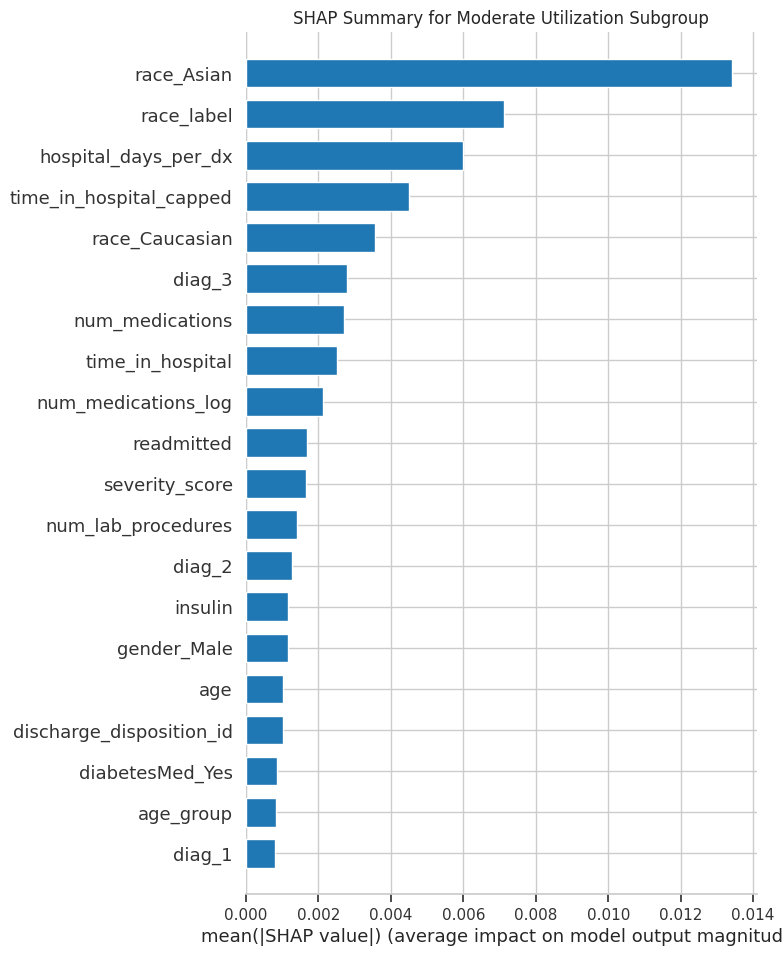

<Figure size 1200x800 with 0 Axes>


Top 5 features for Moderate Utilization: ['race_Asian', 'race_label', 'hospital_days_per_dx', 'time_in_hospital_capped', 'race_Caucasian']
Moderate Utilization Profile:
                         count      mean       std       min       25%  \
hospital_days_per_dx       5.0  0.528571  0.463032  0.166667  0.285714   
time_in_hospital_capped    5.0  3.400000  2.701851  1.000000  2.000000   

                              50%       75%       max  
hospital_days_per_dx     0.428571  0.428571  1.333333  
time_in_hospital_capped  3.000000  3.000000  8.000000  

Cluster 0 vs. Rest: High Risk
5-fold CV scores: [0.98275862 1.         0.98275862 0.98275862 1.        ]
Mean CV Score: 0.9896551724137932
Train Accuracy: 0.9956709956709957
Test Accuracy: 0.9310344827586207


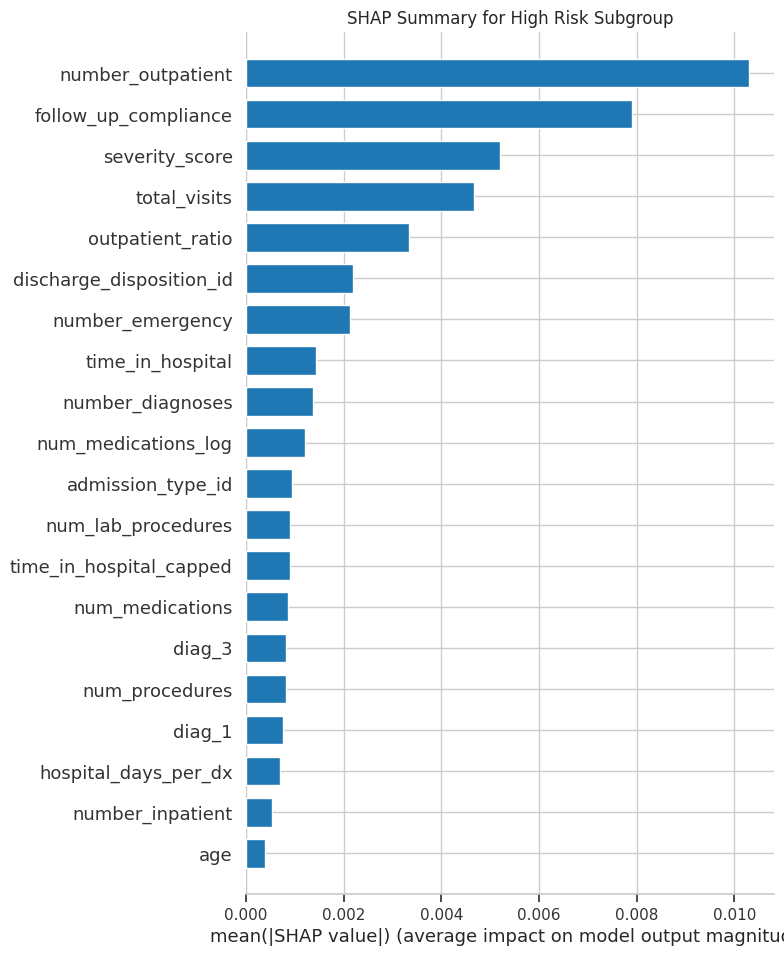

<Figure size 1200x800 with 0 Axes>


Top 5 features for High Risk: ['number_outpatient', 'follow_up_compliance', 'severity_score', 'total_visits', 'outpatient_ratio']
High Risk Profile:
                      count       mean       std    min        25%        50%  \
number_outpatient       7.0   3.857143  1.214986   3.00   3.000000   3.000000   
follow_up_compliance    7.0   1.000000  0.000000   1.00   1.000000   1.000000   
severity_score          7.0  35.904762  5.593363  28.00  33.000000  35.666667   
total_visits            7.0   8.000000  4.000000   4.00   5.000000   6.000000   
outpatient_ratio        7.0   0.565306  0.250185   0.25   0.428571   0.500000   

                         75%        max  
number_outpatient      4.500   6.000000  
follow_up_compliance   1.000   1.000000  
severity_score        39.000  43.666667  
total_visits          11.000  14.000000  
outpatient_ratio       0.675   1.000000  


In [201]:

for target_cluster in unique_clusters:
    # Create a binary target for the current cluster
    df['target'] = (df['cluster_label'] == target_cluster).astype(int)

    # Prepare data for training
    X_for_shap = X_scaled  # same scaled features used for clustering
    y_for_shap = df['target'].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_for_shap,
        y_for_shap,
        test_size=0.2,
        random_state=42
    )

    # Build Random Forest (tune parameters as desired)
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=2,
        max_features="sqrt"
    )
    rf.fit(X_train, y_train)

    # Evaluate model with cross-validation
    cv_scores = cross_val_score(
        rf,
        X_scaled,
        (df['cluster_label'] == target_cluster).astype(int),
        cv=5
    )
    print(f"\nCluster {target_cluster} vs. Rest: {cluster_names.get(target_cluster, 'Unnamed')}")
    print("5-fold CV scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())
    print("Train Accuracy:", rf.score(X_train, y_train))
    print("Test Accuracy:", rf.score(X_test, y_test))

    # Convert X_test back to a DataFrame for SHAP, ensuring columns match X
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # Create the SHAP TreeExplainer
    explainer = shap.TreeExplainer(
        rf,
        model_output="raw",
        feature_perturbation="interventional"
    )
    shap_values = explainer.shap_values(X_test_df)

    # Extract SHAP values for the positive class (membership in the target cluster)
    if len(shap_values.shape) == 3:
        # Fallback for multi-class
        pos_shap = shap_values[:, :, 1]
    else:
        pos_shap = shap_values[1]

    # Generate a summary bar plot
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        pos_shap,
        X_test_df,
        plot_type="bar",
        show=False,  # So we can add a custom title
        color='#1f77b4'  # Optional: set a color, e.g., a shade of blue
    )
    # Add a custom title with cluster name
    plt.title(f"SHAP Summary for {cluster_names.get(target_cluster, 'Unnamed')} Subgroup")
    plt.figure(figsize=(12, 8))
    plt.show()

    # Identify top 5 features by average absolute SHAP
    avg_abs_shap = np.abs(pos_shap).mean(axis=0)
    top_feat_indices = np.argsort(avg_abs_shap)[::-1][:5]
    top_feat_names = [X.columns[i] for i in top_feat_indices]
    print(f"\nTop 5 features for {cluster_names.get(target_cluster, 'Unnamed')}: {top_feat_names}")

    # Print cluster profile
    cluster_subset = df[df['cluster_label'] == target_cluster]
    print(f"{cluster_names.get(target_cluster, 'Unnamed')} Profile:")
    print(cluster_subset[top_feat_names].describe().T)

    # Remove temporary target column
    df.drop('target', axis=1, inplace=True)

## Cluster 1 Profile: Low Engagement Profile

Top 5 features:
['race_Asian', 'number_outpatient', 'total_visits', 'medication_count', 'follow_up_compliance']

Profile details:

number_outpatient: Almost all patients in Cluster 1 have 0 outpatient visits (mean ≈ 0.054).

total_visits: Mean is less than 1, indicating very few total visits.

medication_count: Very low, suggesting minimal changes in medication.

follow_up_compliance: Constantly 0 for all, meaning none of these patients meet the outpatient threshold (which you set as >2).

race_Asian: This feature appears as important; you should check its coding—likely indicating that many patients in this cluster are coded as Asian.

Interpretation:
Cluster 1 seems to consist of patients with very low healthcare utilization (few visits, minimal medication changes, and no follow-up compliance) and might be characterized by a specific racial profile (many Asian patients). You might interpret this as a group that has limited engagement with the healthcare system, which could be due to socioeconomic, cultural, or accessibility factors.

## Cluster 2 Profile: Moderate Utilization Profile

Top 5 features:
['race_Asian', 'race_label', 'hospital_days_per_dx', 'time_in_hospital_capped', 'race_Caucasian']

Profile details:

hospital_days_per_dx: With a mean of ~0.53, patients spend a moderate amount of hospital time per diagnosis.

time_in_hospital_capped: Average of 3.4 days, suggesting a moderate length of stay.

Race features: Both race_Asian and race_Caucasian are among the top features, which may indicate that this cluster has a more mixed racial composition or that these one-hot encoded features are strongly differentiating this group.

Interpretation:
Cluster 2 is small (only 5 patients) and shows moderate hospital utilization. The presence of multiple race indicators suggests this cluster might be capturing a mix of racial groups or possibly an artifact of how race is encoded. Because the cluster size is very small, you may need to re-examine whether it represents a distinct clinical subgroup or if further tuning of clustering parameters is needed.

## Cluster 0 Profile: High Risk Profile

Top 5 features:
['number_outpatient', 'follow_up_compliance', 'total_visits', 'severity_score', 'outpatient_ratio']

Profile details:

number_outpatient: High average outpatient visits (~3.86) among 7 patients.

follow_up_compliance: All patients in this cluster meet the follow-up criterion (value = 1).

total_visits: Average of 8 visits, indicating frequent healthcare usage.

severity_score: Mean of ~35.9 suggests a higher clinical severity, and

outpatient_ratio: Around 0.565 indicates that more than half of their visits are outpatient.

Interpretation:
Cluster 0 appears to represent a high-risk group with frequent outpatient visits, high overall utilization, and higher clinical severity. This group is likely of high interest for interventions since they might benefit from more coordinated care or medication management.

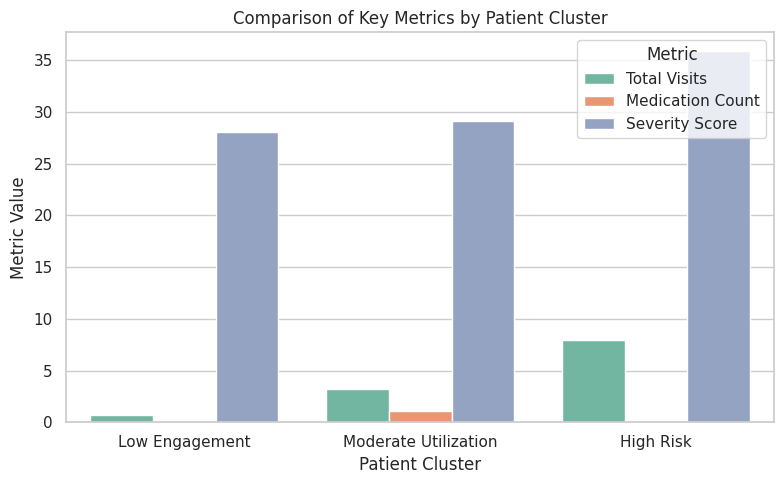

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Actual numbers based on your group summary:
# - Low Engagement (Cluster 1): Total Visits = 0.684615, Medication Count = 0.138462, Severity Score = 28.028205
# - Moderate Utilization (Cluster -1): Total Visits = 3.235294, Medication Count = 1.117647, Severity Score = 29.137255
# - High Risk (Cluster 0): Total Visits = 8.0, Medication Count = 0.0, Severity Score = 35.904762

data = {
    'Cluster': ['Low Engagement', 'Moderate Utilization', 'High Risk'],
    'Total Visits': [0.684615, 3.235294, 8.0],
    'Medication Count': [0.138462, 1.117647, 0.0],
    'Severity Score': [28.028205, 29.137255, 35.904762]
}
df = pd.DataFrame(data)

# Reshape data to long format for a grouped bar chart
df_melted = df.melt(id_vars='Cluster', var_name='Metric', value_name='Value')

plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='Value', hue='Metric', data=df_melted, palette='Set2')
plt.title('Comparison of Key Metrics by Patient Cluster')
plt.xlabel('Patient Cluster')
plt.ylabel('Metric Value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


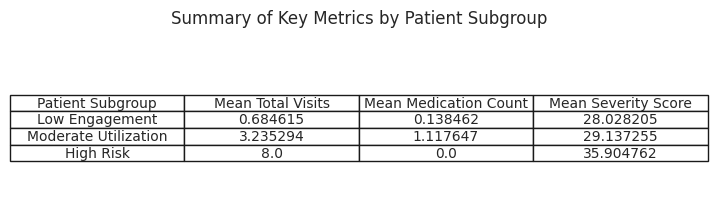

In [210]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Patient Subgroup': ['Low Engagement', 'Moderate Utilization', 'High Risk'],
    'Mean Total Visits': [0.684615, 3.235294, 8.0],
    'Mean Medication Count': [0.138462, 1.117647, 0.0],
    'Mean Severity Score': [28.028205, 29.137255, 35.904762]
}
df_summary = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(9, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_summary.values,
                 colLabels=df_summary.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('Summary of Key Metrics by Patient Subgroup', pad=20)
plt.show()


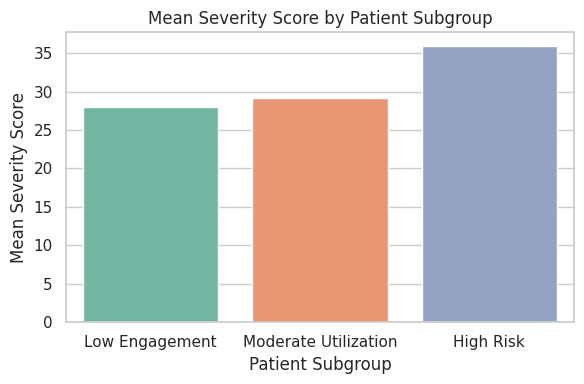

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Patient Subgroup': ['Low Engagement', 'Moderate Utilization', 'High Risk'],
    'Mean Severity Score': [28.028205, 29.137255, 35.904762]
}
df_bar = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.barplot(x='Patient Subgroup', y='Mean Severity Score', data=df_bar, palette='Set2')
plt.title('Mean Severity Score by Patient Subgroup')
plt.xlabel('Patient Subgroup')
plt.ylabel('Mean Severity Score')
plt.tight_layout()
plt.show()


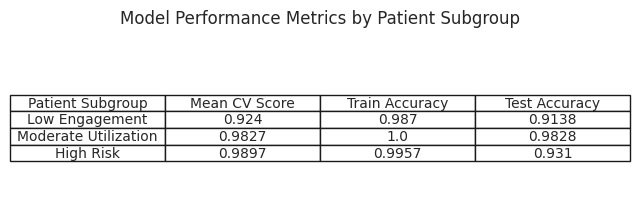

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

# Performance metrics provided (example values)
data_perf = {
    'Patient Subgroup': ['Low Engagement', 'Moderate Utilization', 'High Risk'],
    'Mean CV Score': [0.9240, 0.9827, 0.9897],
    'Train Accuracy': [0.9870, 1.0, 0.9957],
    'Test Accuracy': [0.9138, 0.9828, 0.9310]
}
df_perf = pd.DataFrame(data_perf)

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_perf.values, colLabels=df_perf.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('Model Performance Metrics by Patient Subgroup', pad=20)
plt.show()


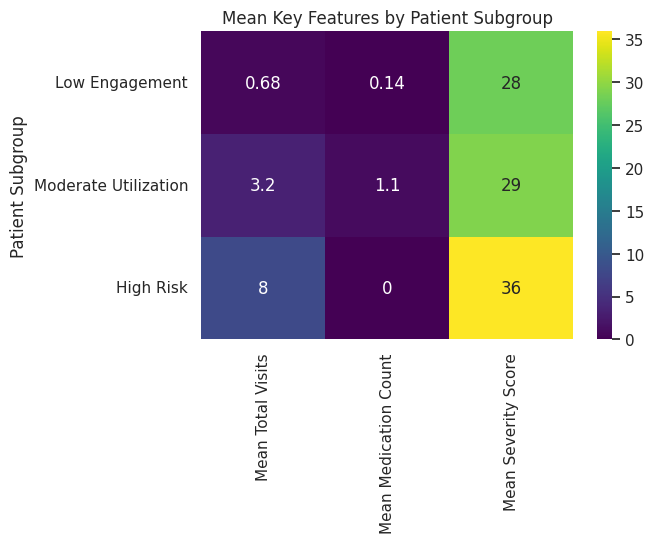

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Patient Subgroup': ['Low Engagement', 'Moderate Utilization', 'High Risk'],
    'Mean Total Visits': [0.684615, 3.235294, 8.0],
    'Mean Medication Count': [0.138462, 1.117647, 0.0],
    'Mean Severity Score': [28.028205, 29.137255, 35.904762]
}
df_heat = pd.DataFrame(data).set_index('Patient Subgroup')

plt.figure(figsize=(6, 4))
sns.heatmap(df_heat, annot=True, cmap='viridis')
plt.title('Mean Key Features by Patient Subgroup')
plt.show()


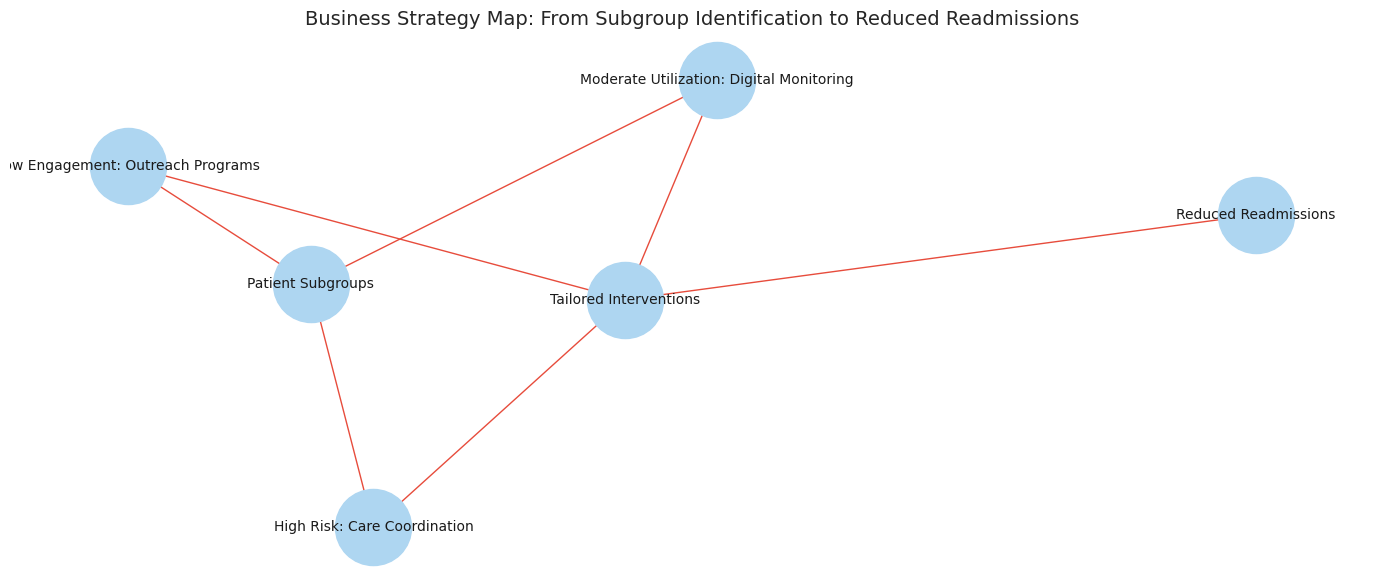

In [207]:
import networkx as nx
import matplotlib.pyplot as plt

# Define nodes for business recommendations with their strategic meaning:
# "Patient Subgroups": Starting point indicating identified patient clusters.
# "High Risk: Care Coordination": Recommendation for the subgroup with high clinical risk.
# "Low Engagement: Outreach Programs": Recommendation for the subgroup with minimal healthcare engagement.
# "Moderate Utilization: Digital Monitoring": Recommendation for the subgroup with stable but watchful patterns.
# "Tailored Interventions": Consolidated strategy combining all subgroup-specific actions.
# "Reduced Readmissions": Ultimate business outcome.

nodes = [
    "Patient Subgroups",
    "High Risk: Care Coordination",
    "Low Engagement: Outreach Programs",
    "Moderate Utilization: Digital Monitoring",
    "Tailored Interventions",
    "Reduced Readmissions"
]

# Define edges showing the flow and connection between recommendations:
# Start from patient subgroups and branch to specific recommendations.
# Each subgroup recommendation then feeds into a consolidated strategy,
# which leads to the ultimate goal of reduced readmissions.
edges = [
    ("Patient Subgroups", "High Risk: Care Coordination"),
    ("Patient Subgroups", "Low Engagement: Outreach Programs"),
    ("Patient Subgroups", "Moderate Utilization: Digital Monitoring"),
    ("High Risk: Care Coordination", "Tailored Interventions"),
    ("Low Engagement: Outreach Programs", "Tailored Interventions"),
    ("Moderate Utilization: Digital Monitoring", "Tailored Interventions"),
    ("Tailored Interventions", "Reduced Readmissions")
]

# Create the directed graph and add nodes and edges
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Use Graphviz 'dot' layout if available for a hierarchical look; otherwise, use spring layout.
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
except:
    pos = nx.spring_layout(G)

plt.figure(figsize=(14, 6))
nx.draw_networkx_nodes(G, pos, node_color='#AED6F1', node_size=3000)
nx.draw_networkx_edges(G, pos, edge_color='#E74C3C', arrows=True, arrowsize=20, arrowstyle='-|>')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.title("Business Strategy Map: From Subgroup Identification to Reduced Readmissions", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


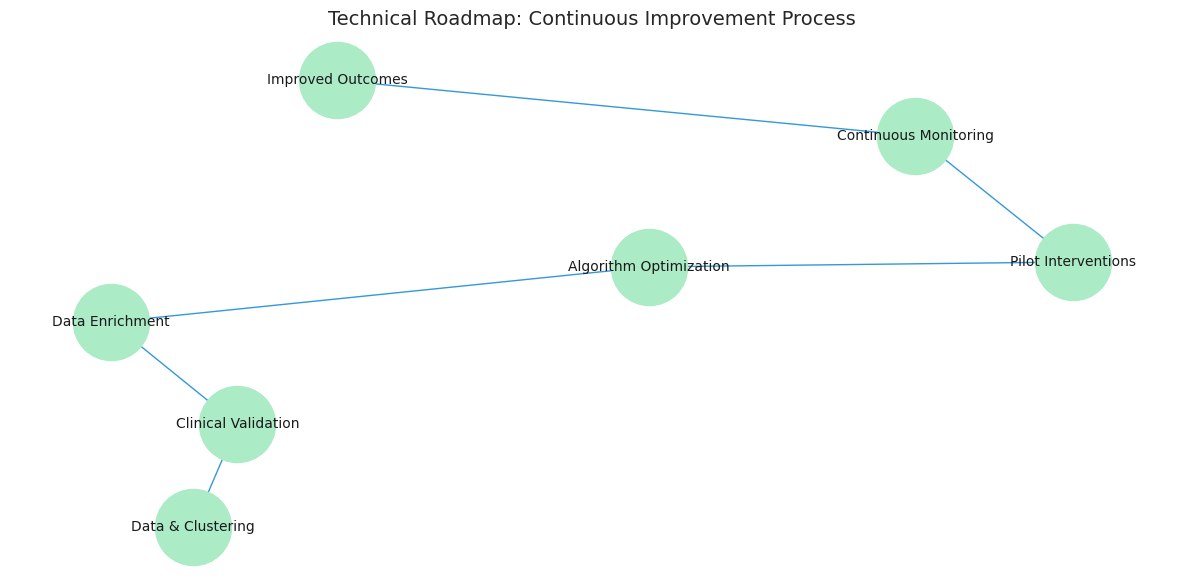

In [208]:
import networkx as nx
import matplotlib.pyplot as plt

# Define nodes for technical next steps with their meaning:
# "Data & Clustering": Initial stage where data is collected and patient clustering is performed.
# "Clinical Validation": Step to collaborate with experts to validate the clusters.
# "Data Enrichment": Incorporating additional data sources for more robust analysis.
# "Algorithm Optimization": Refining and tuning clustering and predictive models.
# "Pilot Interventions": Launching small-scale tests of the recommended interventions.
# "Continuous Monitoring": Ongoing monitoring of outcomes and model performance.
# "Improved Outcomes": The final goal reflecting better patient care and reduced readmissions.

nodes = [
    "Data & Clustering",
    "Clinical Validation",
    "Data Enrichment",
    "Algorithm Optimization",
    "Pilot Interventions",
    "Continuous Monitoring",
    "Improved Outcomes"
]

# Define edges that illustrate the progression through technical steps:
# Each step logically leads to the next, creating a continuous improvement cycle.
edges = [
    ("Data & Clustering", "Clinical Validation"),
    ("Clinical Validation", "Data Enrichment"),
    ("Data Enrichment", "Algorithm Optimization"),
    ("Algorithm Optimization", "Pilot Interventions"),
    ("Pilot Interventions", "Continuous Monitoring"),
    ("Continuous Monitoring", "Improved Outcomes")
]

# Create the directed graph and add nodes and edges.
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Use Graphviz 'dot' layout if available; otherwise, fall back to spring layout.
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
except:
    pos = nx.spring_layout(G)

plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(G, pos, node_color='#ABEBC6', node_size=3000)
nx.draw_networkx_edges(G, pos, edge_color='#3498DB', arrows=True, arrowsize=20, arrowstyle='-|>')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.title("Technical Roadmap: Continuous Improvement Process", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
